In [3]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import scipy.signal as signal
# from google.colab import files

In [2]:
#  uploaded = files.upload()

In [3]:
"""
Script (do not modify)
"""
src_path = 'source_3.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='target_3.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
offsetX = 40
offsetY = 20
mask_path = 'mask_3.bmp'
mask = np.array(Image.open(mask_path)) > 0

In [4]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """ Creates indexes in the target image, each replacement pixel in the
    target image would get index starting from 1, other pixels get 0 in the indexes.

    Args:
    mask: SrcH * SrcW, logical mask of source image
    targetH, targetW: int, height and width of target image
    offsetX, offsetY: int, offset of replacement pixel area from source to target

    Return:
    indexes: targetH * targetW, indexes of target image
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful
    x, y = np.meshgrid(np.arange(mask.shape[1]), np.arange(mask.shape[0]))
    target_x, target_y = x[mask > 0], y[mask > 0]
    indexes = np.zeros((targetH, targetW)).astype(int)
    non_zero = (mask > 0).sum()
    indexes[offsetY+target_y, offsetX+target_x] = np.arange(1, non_zero+1)
    return indexes

In [20]:
def getCoefficientMatrix(indexes):
    """
    constructs the coefficient matrix(A in Ax=b)
    Args: 
    indexes: targetH * targetW, indexes of target image starting from 1, 0 if not in target area 
    returns:
    coeffA: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
    """
    # IMPLEMENT HERE
    # the coefficient matrix is by nature sparse. consider using scipy.sparse.csr_matrixr
    Y,X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)
    
    left = np.zeros(N, dtype=np.int32)
    valid = X - 1 >= 0
    left[valid] = indexes[Y[valid], (X - 1)[valid]] #gives the left neighbor for every point
#     print(right)
    
    right = np.zeros(N, dtype=np.int32)
#     valid = X + 1 <= max(X)
    valid = X + 1 < indexes.shape[1]
    right[valid] = indexes[Y[valid], (X + 1)[valid]] #gives the right neighbor for every point
#     print(right)
    
    top = np.zeros(N, dtype=np.int32)
    valid = Y - 1 >= 0
    top[valid] = indexes[(Y - 1)[valid], X[valid]] #gives the top neighbor for every point
    
    bottom = np.zeros(N, dtype=np.int32)
    valid = Y + 1 < indexes.shape[0]
    bottom[valid] = indexes[(Y + 1)[valid], X[valid]] #gives the bottom neighbor for every point
    
    coeffA = np.zeros((N,N))
    for i in range(N):
        coeffA[i,i] = 4
        if(left[i]-1 >= 0):
            coeffA[i, left[i]-1] = -1
        if(right[i]-1 >= 0):
            coeffA[i, right[i]-1] = -1
        if(top[i]-1 >= 0):
            coeffA[i, top[i]-1] = -1
        if(bottom[i]-1 >= 0):
            coeffA[i, bottom[i]-1] = -1
            
    #convert into sparse matrix       
    A_sparse = scipy.sparse.csr_matrix(coeffA)
    
    A_sparse = A_sparse.toarray() 
    A_sparse = A_sparse.astype(int)
   
    return A_sparse

In [21]:
indexes = np.array([[ 0,  0,  0,  0,  0,  0,  0,  0],
           [ 0,  0,  0,  0,  0,  0,  0,  0],
           [ 0,  0,  0,  0,  0,  0,  0,  0],
           [ 0,  0,  1,  2,  3,  4,  0,  0],
           [ 0,  0,  5,  6,  7,  8,  0,  0],
           [ 0,  0,  9, 10, 11, 12,  0,  0],
           [ 0,  0, 13, 14, 15, 16,  0,  0],
           [ 0,  0,  0,  0,  0,  0,  0,  0]], dtype=np.int32);

In [22]:
A = getCoefficientMatrix(indexes)
print(A)

[[ 4 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1  4 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  4 -1  0  0 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  4  0  0  0 -1  0  0  0  0  0  0  0  0]
 [-1  0  0  0  4 -1  0  0 -1  0  0  0  0  0  0  0]
 [ 0 -1  0  0 -1  4 -1  0  0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0 -1  4 -1  0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0 -1  4  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  4 -1  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0 -1  4 -1  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0  0 -1  4 -1  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1  0  0 -1  4  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0  4 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1  0  0 -1  4 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  4 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  4]]


In [23]:
res = np.array([[ 4, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
           [-1,  4, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
           [ 0, -1,  4, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
           [ 0,  0, -1,  4,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
           [-1,  0,  0,  0,  4, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
           [ 0, -1,  0,  0, -1,  4, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0],
           [ 0,  0, -1,  0,  0, -1,  4, -1,  0,  0, -1,  0,  0,  0,  0,  0],
           [ 0,  0,  0, -1,  0,  0, -1,  4,  0,  0,  0, -1,  0,  0,  0,  0],
           [ 0,  0,  0,  0, -1,  0,  0,  0,  4, -1,  0,  0, -1,  0,  0,  0],
           [ 0,  0,  0,  0,  0, -1,  0,  0, -1,  4, -1,  0,  0, -1,  0,  0],
           [ 0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  4, -1,  0,  0, -1,  0],
           [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  4,  0,  0,  0, -1],
           [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  4, -1,  0,  0],
           [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  4, -1,  0],
           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  4, -1],
           [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  4]],
          dtype=np.int64);

In [24]:
np.where(A - res > 0)

(array([], dtype=int64), array([], dtype=int64))

In [6]:
def getSolutionVect(indexes, source, target, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # 1. get Laplacian part of b from source image
    x, y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))
    X, Y = x[indexes>0], y[indexes>0]
    
    laplacian = np.array([[0, -1, 0], 
                      [-1, 4, -1], 
                      [0, -1, 0]])
    temp_laplacian = scipy.signal.convolve(source, laplacian, 'same')
    Y_src, X_src =Y- offsetY, X - offsetX
    src_laplacian = temp_laplacian[Y_src, X_src]
    
    # 2. get pixel part of b from target image
    Y, X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)
    
    left_idx = np.zeros(N, dtype=np.int32)
    left_val = np.zeros(N, dtype=np.float32)
    valid = X - 1 >= 0
    left_idx[valid] = indexes[Y[valid], (X - 1)[valid]]
    good = np.logical_and(valid, left_idx == 0)
    left_val[good] = target[Y[good], (X - 1)[good]]
    
    right_idx = np.zeros(N, dtype=np.int32)
    right_val = np.zeros(N, dtype=np.float32)
    valid = X + 1 < indexes.shape[1]
    right_idx[valid] = indexes[Y[valid], (X + 1)[valid]]
    good = np.logical_and(valid, right_idx == 0)
    right_val[good] = target[Y[good], (X + 1)[good]]
    
    top_idx = np.zeros(N, dtype=np.int32)
    top_val = np.zeros(N, dtype=np.float32)
    valid = Y - 1 >= 0
    top_idx[valid] = indexes[(Y - 1)[valid], (X)[valid]]
    good = np.logical_and(valid, top_idx == 0)
    top_val[good] = target[(Y - 1)[good], (X)[good]]
    
    bottom_idx = np.zeros(N, dtype=np.int32)
    bottom_val = np.zeros(N, dtype=np.float32)
    valid = Y + 1 < indexes.shape[0]
    bottom_idx[valid] = indexes[(Y + 1)[valid], (X)[valid]]
    good = np.logical_and(valid, bottom_idx == 0)
    bottom_val[good] = target[(Y + 1)[good], (X)[good]]

    # 3. add two parts together to get b
    b = src_laplacian + left_val + right_val + top_val + bottom_val
    return b
    

In [7]:
def solveEqu(A, b):
    """
    solve the equation Ax = b to get replacement pixels x in the replacement area
    Note: A is a sparse matrix, so we need to use coresponding function to solve it

    Args:
    - A: Laplacian coefficient matrix
    - b: target solution vector

    Returns:
    - x: solution of Ax = b
    """
    # IMPLEMENT HERE
    # you may find scipy.sparse.linalg.spsolve 
    
    x = spsolve(A,b)
    
    return x



In [8]:
def reconstructImg(indexes, red, green, blue, targetImg):
    """
    reconstruct the target image with new red, green, blue channel values in th
    e indexes area

    red, green, blue: 1 x N, three chanels for replacement pixels
    """
    # 1. get nonzero component in indexes
    x, y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))
    X, Y = x[indexes>0], y[indexes>0]

    # 2. stack three channels together with numpy dstack

    # 3. copy new pixels in the indexes area to the target image 
    # use numpy copy to make a copy of targetImg, otherwise the original targetImg might change, too
    target_copy = np.copy(targetImg)
    target_copy[Y,X,0] = red
    target_copy[Y,X,1] = green
    target_copy[Y,X,2] = blue
    
    return target_copy


In [9]:
"""
Function (do not modify)
"""
def seamlessCloningPoisson(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and targe image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

/opt/anaconda3/envs/cis581/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


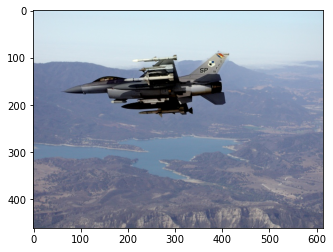

In [10]:
"""
Script (do not modify)
"""
src_path = 'source_3.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='target_3.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
offsetX = 40
offsetY = 20
mask_path = 'mask_3.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = seamlessCloningPoisson(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
cloned = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
cloned.save('cloned.png')
# files.download('cloned.png')

In [11]:
def getSolutionVectMixing(indexes, source, target, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b
    
    # 1. get Laplacian part of b from source image
    x, y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))
    X, Y = x[indexes>0], y[indexes>0]
    
    laplacian = np.array([[0, -1, 0], 
                      [-1, 4, -1], 
                      [0, -1, 0]])
    temp_laplacian = scipy.signal.convolve(source, laplacian, 'same')
    Y_src, X_src =Y- offsetY, X - offsetX
    src_laplacian = temp_laplacian[Y_src, X_src]
    
    #get target laplacian
    temp_laplacian = scipy.signal.convolve(target, laplacian, 'same')
    Y_tgt, X_tgt =Y,X
    tgt_laplacian = temp_laplacian[Y_tgt, X_tgt]
    
    #mixed gradient blending
    b_laplacian = np.where(abs(src_laplacian)>= abs(tgt_laplacian), src_laplacian, tgt_laplacian)
    
    
    
    # 2. get pixel part of b from target image
    Y, X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)
    
    left_idx = np.zeros(N, dtype=np.int32)
    left_val = np.zeros(N, dtype=np.float32)
    valid = X - 1 >= 0
    left_idx[valid] = indexes[Y[valid], (X - 1)[valid]]
    good = np.logical_and(valid, left_idx == 0)
    left_val[good] = target[Y[good], (X - 1)[good]]
    
    right_idx = np.zeros(N, dtype=np.int32)
    right_val = np.zeros(N, dtype=np.float32)
#     valid = X + 1 <= max(X)
    valid = X + 1 < indexes.shape[1]
    right_idx[valid] = indexes[Y[valid], (X + 1)[valid]]
    good = np.logical_and(valid, right_idx == 0)
    right_val[good] = target[Y[good], (X + 1)[good]]
    
    top_idx = np.zeros(N, dtype=np.int32)
    top_val = np.zeros(N, dtype=np.float32)
    valid = Y - 1 >= 0
    top_idx[valid] = indexes[(Y - 1)[valid], (X)[valid]]
    good = np.logical_and(valid, top_idx == 0)
    top_val[good] = target[(Y - 1)[good], (X)[good]]
    
    bottom_idx = np.zeros(N, dtype=np.int32)
    bottom_val = np.zeros(N, dtype=np.float32)
#     valid = Y + 1 <= max(Y)
    valid = Y + 1 < indexes.shape[0]
    bottom_idx[valid] = indexes[(Y + 1)[valid], (X)[valid]]
    good = np.logical_and(valid, bottom_idx == 0)
    bottom_val[good] = target[(Y + 1)[good], (X)[good]]

    # 3. add two parts together to get b
    b = b_laplacian + left_val + right_val + top_val + bottom_val
#     b = b_laplacian
    return b

In [12]:
"""
Function (do not modify)
"""
def PoissonMixing(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and target image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectMixing(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]
    
#     red, green, blue = [
#         getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
#                         offsetX, offsetY).T for i in range(3)
#     ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


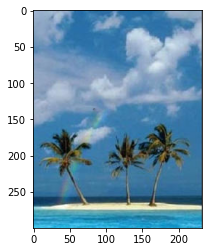

In [13]:
"""
Script (do not modify)
"""
src_path = 'source_2.jpg'
src = Image.open(src_path).convert('RGB')

src = np.array(src, 'f') / 255
target_path  ='target_2.jpg'
target = Image.open(target_path).convert('RGB')
target = np.array(target, 'f') / 255
offsetX = 10
offsetY = 130
mask_path = 'mask_2.bmp'
mask = Image.open(mask_path)
mask =np.array(mask) > 0
result = PoissonMixing(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
mixed = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
mixed.save('mixed.png')
# files.download('mixed.png')

In [84]:

def getSolutionVectTexture(indexes, target, mask, edges):
    """
    constructs the target solution vector(b in Ax=b) 

    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b

    # 1. get Laplacian part of b from source image
    x, y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))
    X, Y = x[indexes>0], y[indexes>0]
    

    #Comparing edge for pixel of interest and neighbouring pixel
    edges_mask = edges[Y,X]
    edges_mask_1 = edges[Y-1,X]
    edges_mask_2 = edges[Y,X-1]
    edges_mask_3 = edges[Y,X+1]
    edges_mask_4 = edges[Y+1,X]
    

    laplacian_1 = np.array([[0, 0, 0], 
                      [0, 1, 0], 
                      [0, -1, 0]])
    laplacian_2 = np.array([[0, 0, 0], 
                      [0, 1, -1], 
                      [0, 0, 0]])
    laplacian_3 = np.array([[0, 0, 0], 
                      [-1, 1, 0], 
                      [0, 0, 0]])
    laplacian_4 = np.array([[0, -1, 0], 
                      [0, 1, 0], 
                      [0, 0, 0]])
    
    
    temp_laplacian_1 = scipy.signal.convolve(target, laplacian_1, 'same')
    tgt_laplacian_1 = temp_laplacian_1[Y, X]
    
    temp_laplacian_2 = scipy.signal.convolve(target, laplacian_2, 'same')
    tgt_laplacian_2 = temp_laplacian_2[Y, X]
    
    temp_laplacian_3 = scipy.signal.convolve(target, laplacian_3, 'same')
    tgt_laplacian_3 = temp_laplacian_3[Y, X]
    
    temp_laplacian_4 = scipy.signal.convolve(target, laplacian_4, 'same')
    tgt_laplacian_4 = temp_laplacian_4[Y, X]

    b_laplacian_1 = np.where((edges_mask + edges_mask_1) >0, tgt_laplacian_1, 0)
    b_laplacian_2 = np.where((edges_mask + edges_mask_2) >0, tgt_laplacian_2, 0)
    b_laplacian_3 = np.where((edges_mask + edges_mask_3) >0, tgt_laplacian_3, 0)
    b_laplacian_4 = np.where((edges_mask + edges_mask_4) >0, tgt_laplacian_4, 0)
    
    b_laplacian = b_laplacian_1 + b_laplacian_2 + b_laplacian_3 + b_laplacian_4


    # 2. get pixel part of b from target image
    Y, X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)

    left_idx = np.zeros(N, dtype=np.int32)
    left_val = np.zeros(N, dtype=np.float32)
    valid = X - 1 >= 0
    left_idx[valid] = indexes[Y[valid], (X - 1)[valid]]
    good = np.logical_and(valid, left_idx == 0)
    left_val[good] = target[Y[good], (X - 1)[good]]

    right_idx = np.zeros(N, dtype=np.int32)
    right_val = np.zeros(N, dtype=np.float32)
    valid = X + 1 < indexes.shape[1]
    right_idx[valid] = indexes[Y[valid], (X + 1)[valid]]
    good = np.logical_and(valid, right_idx == 0)
    right_val[good] = target[Y[good], (X + 1)[good]]

    top_idx = np.zeros(N, dtype=np.int32)
    top_val = np.zeros(N, dtype=np.float32)
    valid = Y - 1 >= 0
    top_idx[valid] = indexes[(Y - 1)[valid], (X)[valid]]
    good = np.logical_and(valid, top_idx == 0)
    top_val[good] = target[(Y - 1)[good], (X)[good]]

    bottom_idx = np.zeros(N, dtype=np.int32)
    bottom_val = np.zeros(N, dtype=np.float32)
    valid = Y + 1 < indexes.shape[0]
    bottom_idx[valid] = indexes[(Y + 1)[valid], (X)[valid]]
    good = np.logical_and(valid, bottom_idx == 0)
    bottom_val[good] = target[(Y + 1)[good], (X)[good]]

    # 3. add two parts together to get b
    b = b_laplacian + left_val + right_val + top_val + bottom_val

    return b


In [85]:
"""
Function (do not modify)
"""
def PoissonTextureFlattening(targetImg, mask, edges):
    """
    Wrapper function to put all steps together
    Args:
    - targetImg: target image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectTexture(indexes, targetImg[:, :, i], mask, edges).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                                   targetImg)
    return resultImg


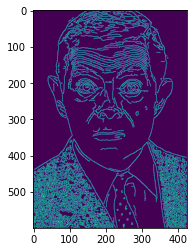

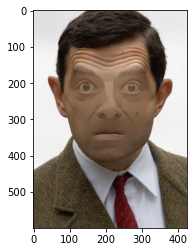

In [86]:
"""
Script (do not modify)
"""
target_path  ='bean.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
from skimage.color import rgb2gray
from skimage import feature
edges = feature.canny(rgb2gray(target))
plt.imshow(edges)
plt.show()
mask_path = 'mask_bean.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = PoissonTextureFlattening(target, mask, edges)
plt.imshow(result)
plt.show()
flatten = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
flatten.save('flatten.png')
# files.download('flatten.png')